# Лабораторная работа №2
### Группа ИУ5-22М
### Щипицина К.В.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from IPython.display import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

## Загрузка и первичный анализ данных

In [2]:
data = pd.read_csv("C:\\Users\\ksenv\\Desktop\\loan_data_set.csv")

In [3]:
data.shape

(614, 13)

In [4]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [5]:
data.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Обработкa пропусков в данных

In [6]:
# типы колонок
data.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [7]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [8]:
# Колонки с пропусками
cols_with_na = [c for c in data.columns if data[c].isnull().sum() > 0]
cols_with_na

['Gender',
 'Married',
 'Dependents',
 'Self_Employed',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [9]:
# Доля (процент) пропусков
[(c, data[c].isnull().mean()) for c in cols_with_na]

[('Gender', 0.021172638436482084),
 ('Married', 0.004885993485342019),
 ('Dependents', 0.024429967426710098),
 ('Self_Employed', 0.05211726384364821),
 ('LoanAmount', 0.035830618892508145),
 ('Loan_Amount_Term', 0.02280130293159609),
 ('Credit_History', 0.08143322475570032)]

Датасет достаточно маленький, а доля пропущенных значений не очень большая. В таком случае можно поработать с внедрением пропущенных значений.

### Заполнение значений для одного признака

In [10]:
# Пример работы MissingIndicator
temp_x1 = np.array([[np.nan, 1, 3], [np.nan, 0, 5], [3,np.nan, 1]])
print('Исходный массив:')
print(temp_x1)
indicator = MissingIndicator(features='all')
temp_x1_transformed = indicator.fit_transform(temp_x1)
print('Маска пропущенных значений:')
print(temp_x1_transformed)

Исходный массив:
[[nan  1.  3.]
 [nan  0.  5.]
 [ 3. nan  1.]]
Маска пропущенных значений:
[[ True False False]
 [ True False False]
 [False  True False]]


In [11]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imputer = SimpleImputer(strategy=strategy_param, 
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)
    
    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]
    
    return all_data.reshape((size,)), filled_data, missed_data

In [12]:
def research_impute_numeric_column(dataset, num_column, const_value=None):
    strategy_params = ['mean', 'median', 'most_frequent', 'constant']
    strategy_params_names = ['Среднее', 'Медиана', 'Мода']
    strategy_params_names.append('Константа = ' + str(const_value))
    
    original_temp_data = dataset[[num_column]].values
    size = original_temp_data.shape[0]
    original_data = original_temp_data.reshape((size,))
    
    new_df = pd.DataFrame({'Исходные данные':original_data})
       
    for i in range(len(strategy_params)):
        strategy = strategy_params[i]
        col_name = strategy_params_names[i]
        if (strategy!='constant') or (strategy == 'constant' and const_value!=None):
            if strategy == 'constant':
                temp_data, _, _ = impute_column(dataset, num_column, strategy, fill_value_param=const_value)
            else:
                temp_data, _, _ = impute_column(dataset, num_column, strategy)
            new_df[col_name] = temp_data
        
    sns.kdeplot(data=new_df)

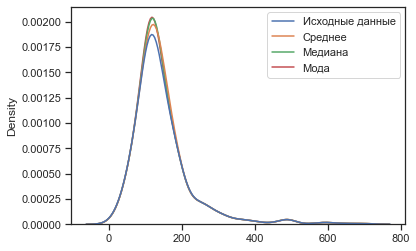

In [13]:
research_impute_numeric_column(data, 'LoanAmount')

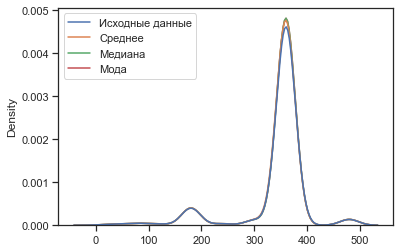

In [14]:
research_impute_numeric_column(data, 'Loan_Amount_Term')

Распределения одномодальные, поэтому можно использовать для импутации моду.

In [15]:
data_imp=data.copy(deep=True)
LoanAmount_new, _,_ = impute_column(data_imp, 'LoanAmount', 'most_frequent')

In [16]:
data_imp['LoanAmount']=LoanAmount_new

In [17]:
data_imp.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

### Для категориальных признаков

In [18]:
hdata_cat_cols = ['Gender', 'Married', 'Dependents','Self_Employed']
hdata_cat_new = data[hdata_cat_cols].copy(deep=True)

In [19]:
Gender_cat_new_temp, _, _ = impute_column(hdata_cat_new, 'Gender', 'most_frequent')
Married_cat_new_temp, _, _ = impute_column(hdata_cat_new, 'Married', 'most_frequent')
Dependents_cat_new_temp, _, _ = impute_column(hdata_cat_new, 'Dependents', 'most_frequent')
Self_Employed_cat_new_temp, _, _ = impute_column(hdata_cat_new, 'Self_Employed', 'most_frequent')


In [20]:
hdata_cat_new['Gender'] = Gender_cat_new_temp
hdata_cat_new['Married'] = Married_cat_new_temp
hdata_cat_new['Dependents'] = Dependents_cat_new_temp
hdata_cat_new['Self_Employed'] = Self_Employed_cat_new_temp


In [21]:
data_imp_cat=data.copy()
data_imp_cat['Gender'] = Gender_cat_new_temp
data_imp_cat['Married'] = Married_cat_new_temp
data_imp_cat['Self_Employed'] = Self_Employed_cat_new_temp


In [22]:
data_imp_cat.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [23]:
def plot_hist_diff(old_ds, new_ds, cols):
    """
    
    """
    for c in cols:   
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.title.set_text('Поле - ' + str(c))
        old_ds[c].hist(bins=4, ax=ax, density=False, color='blue')
        new_ds[c].hist(bins=4, ax=ax, color='green', density=False, alpha=0.5)
        plt.show()

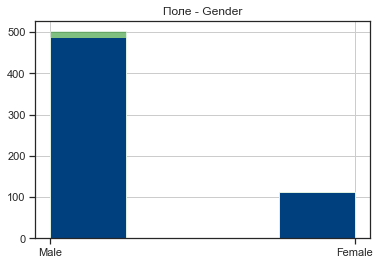

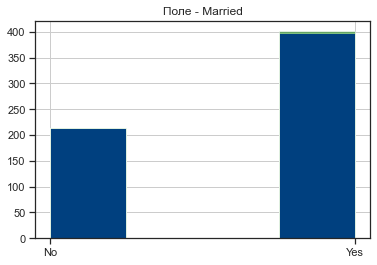

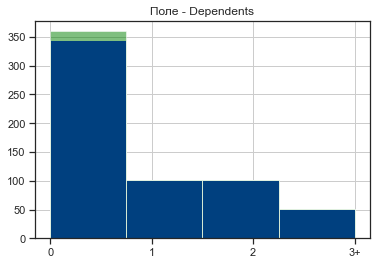

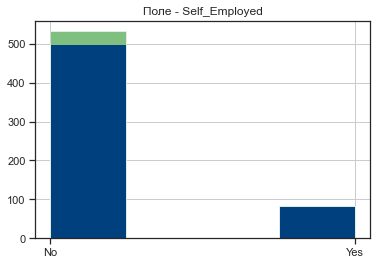

In [24]:
plot_hist_diff(data, hdata_cat_new, hdata_cat_cols)

### KNN

In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_knn=data_imp_cat.copy(deep=True) # устранены пропуски строковых признаков
data_knn['Gender'] = le.fit_transform(data['Gender'])
data_knn['Married'] = le.fit_transform(data['Married'])
data_knn['Education'] = le.fit_transform(data['Education'])
data_knn['Self_Employed'] = le.fit_transform(data['Self_Employed'])
data_knn['Property_Area'] = le.fit_transform(data['Property_Area'])
data_knn['Dependents'] = le.fit_transform(data['Dependents'])

In [26]:
knnimpute_cols = ['Dependents', 'LoanAmount','Loan_Amount_Term', 'Credit_History']

In [27]:
knnimpute_hdata = data_knn[knnimpute_cols].copy()
knnimpute_hdata.head()

,Dependents,LoanAmount,Loan_Amount_Term,Credit_History
0,0,NaN,360.0,1.0
1,1,128.0,360.0,1.0
2,0,66.0,360.0,1.0
3,0,120.0,360.0,1.0
4,0,141.0,360.0,1.0


In [28]:
# Признаки с пропусками
knnimpute_hdata.isnull().sum()

Dependents           0
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64

In [29]:
knnimputer = KNNImputer(
    n_neighbors=5, 
    weights='distance', 
    metric='nan_euclidean', 
    add_indicator=False, 
)
knnimpute_hdata_imputed_temp = knnimputer.fit_transform(knnimpute_hdata)
knnimpute_hdata_imputed = pd.DataFrame(knnimpute_hdata_imputed_temp, columns=knnimpute_hdata.columns)
knnimpute_hdata_imputed.head()

,Dependents,LoanAmount,Loan_Amount_Term,Credit_History
0,0.0,120.8,360.0,1.0
1,1.0,128.0,360.0,1.0
2,0.0,66.0,360.0,1.0
3,0.0,120.0,360.0,1.0
4,0.0,141.0,360.0,1.0


In [30]:
# Пропуски заполнены
knnimpute_hdata_imputed.isnull().sum()

Dependents          0
LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
dtype: int64

<AxesSubplot:ylabel='Density'>

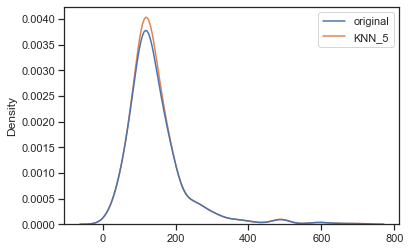

In [31]:
LoanAmount_df = pd.DataFrame({'original': knnimpute_hdata['LoanAmount'].values})
LoanAmount_df['KNN_5'] = knnimpute_hdata_imputed['LoanAmount']
sns.kdeplot(data=LoanAmount_df)

## кодирование категориальных признаков

In [32]:
data_=data.copy(deep=True)
LoanAmount_new, _,_ = impute_column(data_, 'LoanAmount', 'most_frequent')
Loan_Amount_Term_new, _,_ = impute_column(data_, 'Loan_Amount_Term', 'most_frequent')
Credit_History_new, _,_ = impute_column(data_, 'Credit_History', 'most_frequent')

Gender_cat_new_temp, _, _ = impute_column(data_, 'Gender', 'most_frequent')
Married_cat_new_temp, _, _ = impute_column(data_, 'Married', 'most_frequent')
Education_cat_new_temp, _, _ = impute_column(data_, 'Education', 'most_frequent')
Self_Employed_cat_new_temp, _, _ = impute_column(data_, 'Self_Employed', 'most_frequent')
Property_Area_cat_new_temp, _, _ = impute_column(data_, 'Property_Area', 'most_frequent')
Dependents_cat_new_temp, _, _ = impute_column(data_, 'Dependents', 'most_frequent')

In [33]:
data_['LoanAmount'] = LoanAmount_new
data_['Loan_Amount_Term']=Loan_Amount_Term_new
data_['Credit_History']=Credit_History_new
data_['Gender'] = Gender_cat_new_temp
data_['Married'] = Married_cat_new_temp
data_['Education'] = Education_cat_new_temp
data_['Self_Employed'] = Self_Employed_cat_new_temp
data_['Property_Area'] = Property_Area_cat_new_temp
data_['Dependents'] = Dependents_cat_new_temp

In [34]:
data_=data_.drop(['Loan_ID'], axis=1)
data_['Loan_Status'] = le.fit_transform(data_['Loan_Status'])

## label encoding

In [35]:
data_.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,120.0,360.0,1.0,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1


In [36]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_Lable_enc=data_.copy(deep=True)
data_Lable_enc['Gender'] = le.fit_transform(data_['Gender'])
print(data_Lable_enc['Gender'].unique())
print(le.inverse_transform([1,0]))
data_Lable_enc['Married'] = le.fit_transform(data_Lable_enc['Married'])
data_Lable_enc['Education'] = le.fit_transform(data_Lable_enc['Education'])
data_Lable_enc['Self_Employed'] = le.fit_transform(data_Lable_enc['Self_Employed'])
data_Lable_enc['Property_Area'] = le.fit_transform(data_Lable_enc['Property_Area'])

[1 0]
['Male' 'Female']


In [37]:
data_Lable_enc.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.0,120.0,360.0,1.0,2,1
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1


## one-hot encoding

In [38]:
data_dumm=data_.copy(deep=True)

In [39]:
# Добавление отдельной колонки, признака пустых значений
pd.get_dummies(data_dumm[['Gender']], dummy_na=True).head()

,Gender_Female,Gender_Male,Gender_nan
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [40]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    original_dataframe = pd.concat([original_dataframe, dummies], axis=1)
    original_dataframe = original_dataframe.drop(feature_to_encode,axis = 1)
    return original_dataframe

In [41]:
data_dumm=encode_and_bind(data_dumm, 'Gender')

In [42]:
data_dumm.head()

,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Gender_Female,Gender_Male
0,No,0,Graduate,No,5849,0.0,120.0,360.0,1.0,Urban,1,0,1
1,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,0,1
2,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,0,1
3,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,0,1
4,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,0,1


In [43]:
data=data_.copy(deep=True)

In [44]:
from category_encoders.one_hot import OneHotEncoder as ce_OneHotEncoder

In [45]:
ce_OneHotEncoder1 = ce_OneHotEncoder()
data_OHE = ce_OneHotEncoder1.fit_transform(data_[data_.columns.difference(['Loan_Status'])])

In [46]:
data_OHE

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents_1,Dependents_2,Dependents_3,Dependents_4,Education_1,Education_2,Gender_1,Gender_2,LoanAmount,Loan_Amount_Term,Married_1,Married_2,Property_Area_1,Property_Area_2,Property_Area_3,Self_Employed_1,Self_Employed_2
0,5849,0.0,1.0,1,0,0,0,1,0,1,0,120.0,360.0,1,0,1,0,0,1,0
1,4583,1508.0,1.0,0,1,0,0,1,0,1,0,128.0,360.0,0,1,0,1,0,1,0
2,3000,0.0,1.0,1,0,0,0,1,0,1,0,66.0,360.0,0,1,1,0,0,0,1
3,2583,2358.0,1.0,1,0,0,0,0,1,1,0,120.0,360.0,0,1,1,0,0,1,0
4,6000,0.0,1.0,1,0,0,0,1,0,1,0,141.0,360.0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,1.0,1,0,0,0,1,0,0,1,71.0,360.0,1,0,0,1,0,1,0
610,4106,0.0,1.0,0,0,0,1,1,0,1,0,40.0,180.0,0,1,0,1,0,1,0
611,8072,240.0,1.0,0,1,0,0,1,0,1,0,253.0,360.0,0,1,1,0,0,1,0
612,7583,0.0,1.0,0,0,1,0,1,0,1,0,187.0,360.0,0,1,1,0,0,1,0


## Count (frequency) encoding

In [47]:
from category_encoders.count import CountEncoder as ce_CountEncoder

In [48]:
data_

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,120.0,360.0,1.0,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,1
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,1
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,1
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,1


In [49]:
ce_CountEncoder1 = ce_CountEncoder()
data_COUNT_ENC = ce_CountEncoder1.fit_transform(data_[data_.columns.difference(['Loan_Status'])])

In [50]:
data_COUNT_ENC

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Married,Property_Area,Self_Employed
0,5849,0.0,1.0,360,480,502,120.0,360.0,213,202,532
1,4583,1508.0,1.0,102,480,502,128.0,360.0,401,179,532
2,3000,0.0,1.0,360,480,502,66.0,360.0,401,202,82
3,2583,2358.0,1.0,360,134,502,120.0,360.0,401,202,532
4,6000,0.0,1.0,360,480,502,141.0,360.0,213,202,532
...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,1.0,360,480,112,71.0,360.0,213,179,532
610,4106,0.0,1.0,51,480,502,40.0,180.0,401,179,532
611,8072,240.0,1.0,102,480,502,253.0,360.0,401,202,532
612,7583,0.0,1.0,101,480,502,187.0,360.0,401,202,532


In [51]:
data_['Property_Area'].unique()

array(['Urban', 'Rural', 'Semiurban'], dtype=object)

In [52]:
data_COUNT_ENC['Property_Area'].unique()

array([202, 179, 233], dtype=int64)

## Target (Mean) encoding

In [53]:
# На самом деле этот метод реализует Mean encoding
from category_encoders.target_encoder import TargetEncoder as ce_TargetEncoder

In [54]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#data_6=data.copy(deep=True)
#data_6['Loan_Status'] = le.fit_transform(data_6['Loan_Status'])

In [55]:

ce_TargetEncoder1 = ce_TargetEncoder()
data_MEAN_ENC = ce_TargetEncoder1.fit_transform(data_[data_.columns.difference(['Loan_Status'])], data_['Loan_Status'])

In [56]:
data_MEAN_ENC


,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Married,Property_Area,Self_Employed
0,5849,0.0,1.0,0.686111,0.708333,0.691235,120.0,360.0,0.629108,0.658416,0.687970
1,4583,1508.0,1.0,0.647059,0.708333,0.691235,128.0,360.0,0.718204,0.614525,0.687970
2,3000,0.0,1.0,0.686111,0.708333,0.691235,66.0,360.0,0.718204,0.658416,0.682927
3,2583,2358.0,1.0,0.686111,0.611940,0.691235,120.0,360.0,0.718204,0.658416,0.687970
4,6000,0.0,1.0,0.686111,0.708333,0.691235,141.0,360.0,0.629108,0.658416,0.687970
...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,1.0,0.686111,0.708333,0.669643,71.0,360.0,0.629108,0.614525,0.687970
610,4106,0.0,1.0,0.647059,0.708333,0.691235,40.0,180.0,0.718204,0.614525,0.687970
611,8072,240.0,1.0,0.647059,0.708333,0.691235,253.0,360.0,0.718204,0.658416,0.687970
612,7583,0.0,1.0,0.752475,0.708333,0.691235,187.0,360.0,0.718204,0.658416,0.687970


In [57]:
data_['Property_Area'].unique()

array(['Urban', 'Rural', 'Semiurban'], dtype=object)

In [58]:
data_MEAN_ENC['Property_Area'].unique()

array([0.65841584, 0.61452514, 0.76824034])

In [59]:
def check_mean_encoding(field):
    for s in data[field].unique():
        data_filter = data_[data_[field]==s]
        if data_filter.shape[0] > 0:
            prob = sum(data_filter['Loan_Status']) / data_filter.shape[0]
            print(s, '-' , prob)

In [60]:
check_mean_encoding('Property_Area')

Urban - 0.6584158415841584
Rural - 0.6145251396648045
Semiurban - 0.7682403433476395


## Weight of evidence (WoE) encoding

In [61]:
from category_encoders.woe import WOEEncoder as ce_WOEEncoder

In [62]:
ce_WOEEncoder1 = ce_WOEEncoder()
data_WOE_ENC = ce_WOEEncoder1.fit_transform(data_[data_.columns.difference(['Loan_Status'])], data_['Loan_Status'])

In [63]:
data_WOE_ENC

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Married,Property_Area,Self_Employed
0,5849,0.0,1.0,-0.004645,0.101247,0.020471,120.0,360.0,-0.258627,-0.132531,0.005493
1,4583,1508.0,1.0,-0.188101,0.101247,0.020471,128.0,360.0,0.148353,-0.320840,0.005493
2,3000,0.0,1.0,-0.004645,0.101247,0.020471,66.0,360.0,0.148353,-0.132531,-0.034661
3,2583,2358.0,1.0,-0.004645,-0.333327,0.020471,120.0,360.0,0.148353,-0.132531,0.005493
4,6000,0.0,1.0,-0.004645,0.101247,0.020471,141.0,360.0,-0.258627,-0.132531,0.005493
...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,1.0,-0.004645,0.101247,-0.088728,71.0,360.0,-0.258627,-0.320840,0.005493
610,4106,0.0,1.0,-0.199954,0.101247,0.020471,40.0,180.0,0.148353,-0.320840,0.005493
611,8072,240.0,1.0,-0.188101,0.101247,0.020471,253.0,360.0,0.148353,-0.132531,0.005493
612,7583,0.0,1.0,0.303834,0.101247,0.020471,187.0,360.0,0.148353,-0.132531,0.005493


In [64]:
# Проверка для поля "Пол"
data_['Property_Area'].unique()

array(['Urban', 'Rural', 'Semiurban'], dtype=object)

In [65]:
data_WOE_ENC['Property_Area'].unique()

array([-0.13253074, -0.32084034,  0.40374837])

In [66]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.3, a-0.05, str(round(b,3)), color='white')
        plt.show()    

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [68]:
clas_models_dict = {'LogR': LogisticRegression(max_iter=1000), 
                    'KNN_5':KNeighborsClassifier(n_neighbors=5),
                    'Tree':DecisionTreeClassifier(),
                    'GB': GradientBoostingClassifier(),
                    'RF':RandomForestClassifier(n_estimators=50, random_state=1, max_depth=3)}

In [69]:
X_data_dict = {
               'One-Hot encoding': data_OHE, 
               'Count encoding': data_COUNT_ENC,
               'Mean encoding': data_MEAN_ENC,
               'Weight of evidence encoding': data_WOE_ENC,
               
              }

In [70]:
def test_models(clas_models_dict, X_data_dict, y_data):
    
    logger = MetricLogger()
    
    for model_name, model in clas_models_dict.items():
        
        for data_name, X_data in X_data_dict.items():
    
            X_train, X_test, y_train, y_test = train_test_split(
                X_data, y_data, test_size=0.3, random_state=1)
        
            model.fit(X_train, y_train)
            pred1 = model.predict_proba(X_train)
            pred2 = model.predict_proba(X_test)
            roc_auc = roc_auc_score(y_test, pred2[:, 1])
            logger.add(model_name, data_name, roc_auc)
            
    return logger

In [71]:
%%time
logger = test_models(clas_models_dict, X_data_dict, data['Loan_Status'])

Wall time: 1.23 s


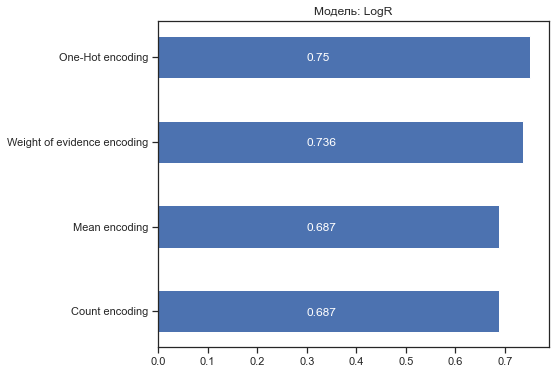

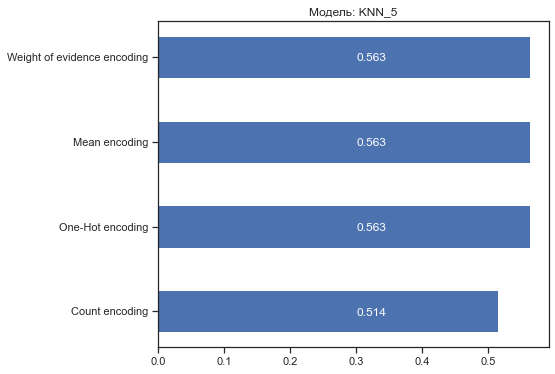

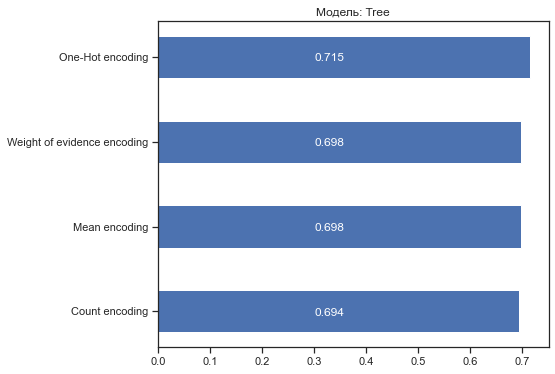

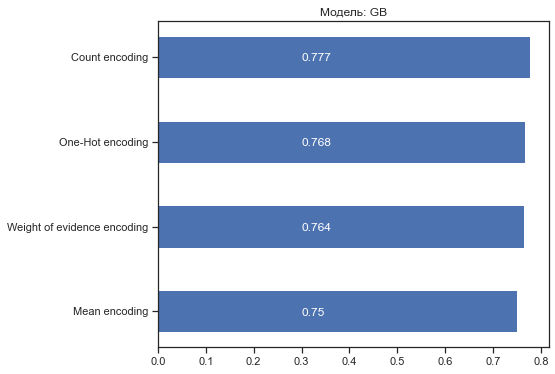

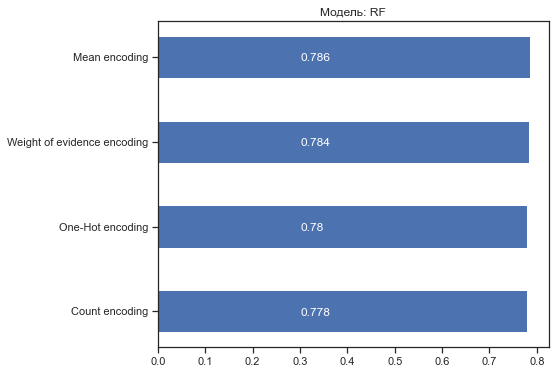

In [72]:
# Построим графики метрик качества модели
for model in clas_models_dict:
    logger.plot('Модель: ' + model, model, figsize=(7, 6))

## нормализация числовых признаков


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

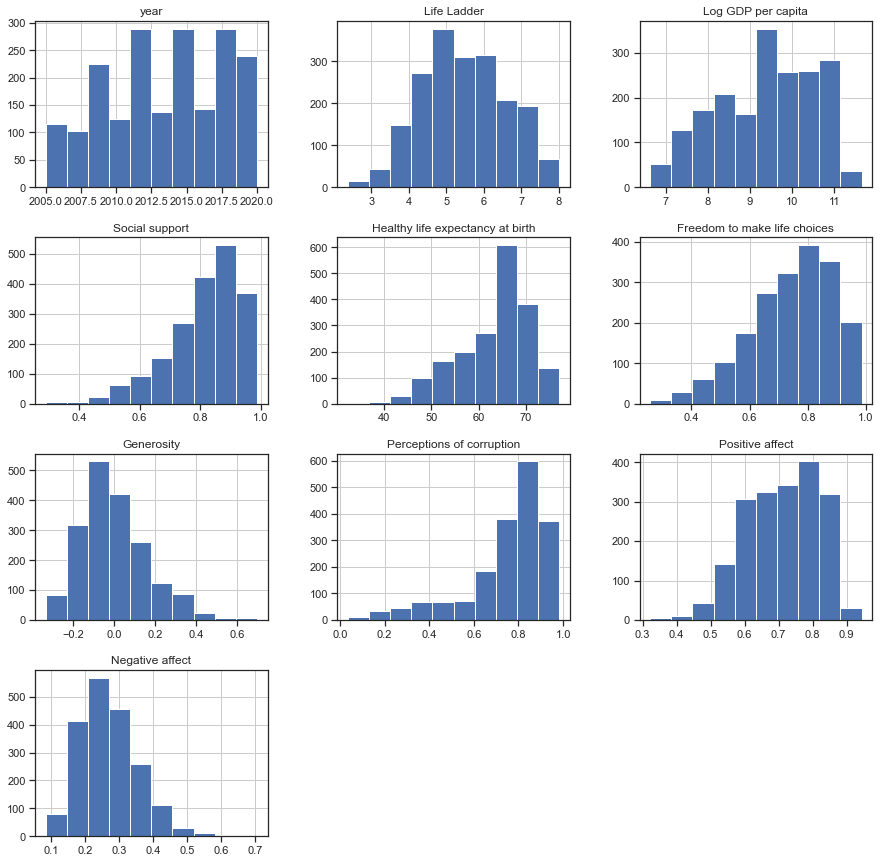

In [74]:
data = pd.read_csv("C:\\Users\\ksenv\\Desktop\\world-happiness-report.csv")
data.hist(figsize=(15,15))
plt.show()

In [75]:
data.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


In [76]:
data.shape

(1949, 11)

In [77]:
data = data.dropna(subset=['Perceptions of corruption'],axis=0)

In [78]:
data = data[data['Perceptions of corruption'] != 0]

In [79]:

def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

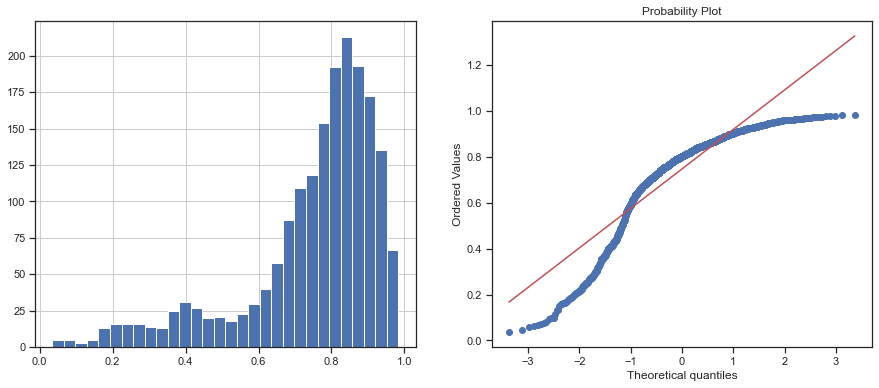

In [80]:
diagnostic_plots(data, 'Perceptions of corruption')

## Логарифмическое преобразование

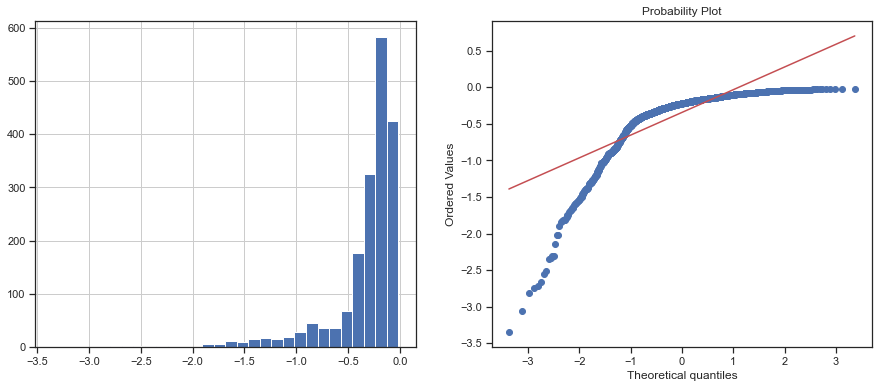

In [81]:
data['Perceptions of corruption log'] = np.log(data['Perceptions of corruption'])
diagnostic_plots(data, 'Perceptions of corruption log')

## Обратное преобразование


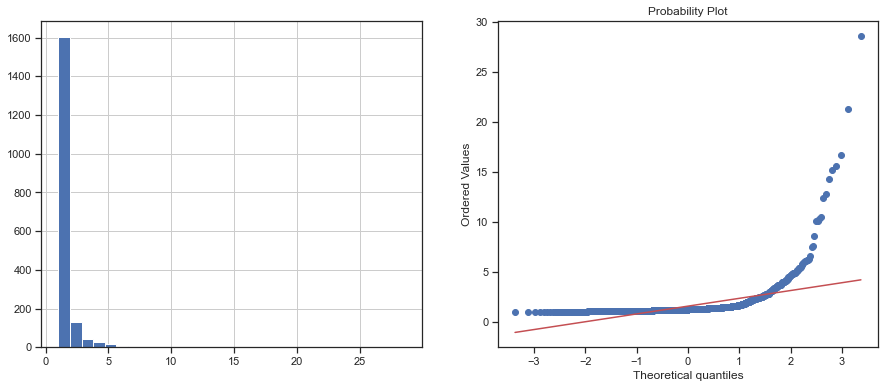

In [82]:
data['Perceptions of corruption reciprocal'] = 1 / (data['Perceptions of corruption']) 
diagnostic_plots(data, 'Perceptions of corruption reciprocal')

## Преобразование Бокса-Кокса

Оптимальное значение λ = 2.7700421323976836


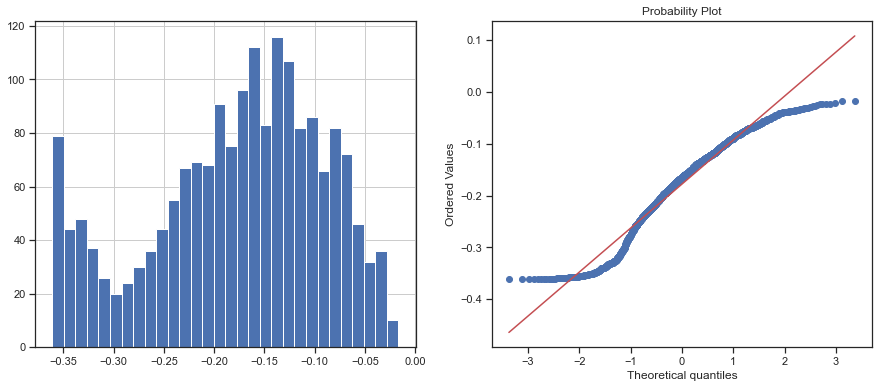

In [83]:
data['Perceptions of corruption boxcox'], param = stats.boxcox(data['Perceptions of corruption']) 
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(data, 'Perceptions of corruption boxcox')

## Преобразование Йео-Джонсона


Оптимальное значение λ = 6.538818034440224


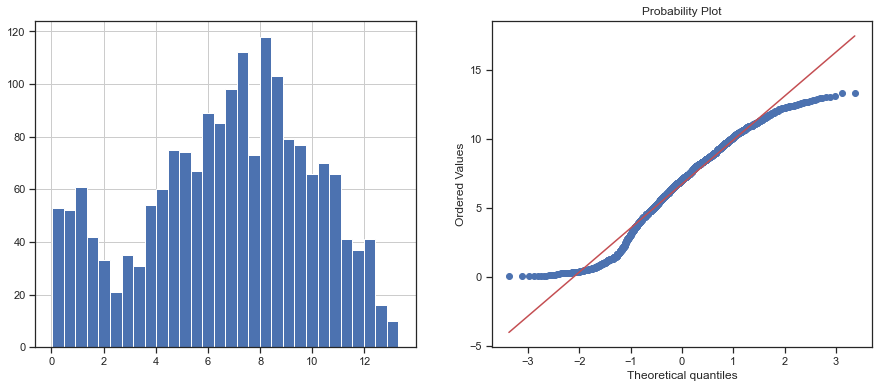

In [84]:
# Необходимо преобразовать данные к действительному типу

data['Perceptions of corruption yeojohnson'], param = stats.yeojohnson(data['Perceptions of corruption']) 
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(data, 'Perceptions of corruption yeojohnson')

## Возведение в степень

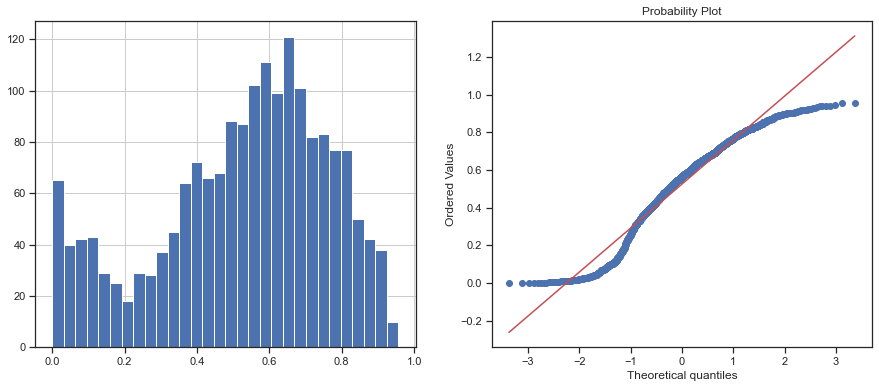

In [85]:
data['Perceptions of corruption exp'] = data['Perceptions of corruption']**(2.6)
diagnostic_plots(data, 'Perceptions of corruption exp')